# Stochastic Simulations - group project

## Project 4 : Variance reduction in Monte Carlo integration via function approximation

Francesca Bettinelli \
Marianna Dell'Otto \
Sophie Lequeu

In [1]:
from question2 import *
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Question 2
#### a) Crude Monte Carlo estimator

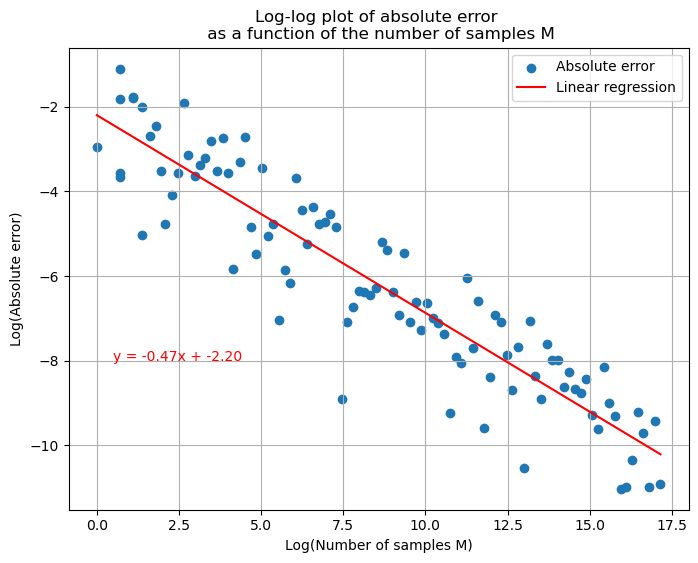

In [2]:
# exact value of the integral (reference)
ref_value = (1/5) * np.arctan(5)

# crude Monte Carlo estimators
N = 100
nb_samples = [math.ceil(np.power(2, 1/4)**n) for n in range(N)]
CMC_estims = np.zeros(N)
for M in range(N):
    unif_samps = np.random.uniform(0, 1, nb_samples[M])
    CMC_estims[M] = crude_MC(unif_samps, f)

# plot log-log graph to see order of the error
loglog_graph(nb_samples, CMC_estims, ref_value)


Plotting the error of the crude Monte Carlo estimator for different values of M (in log-log scale), we observe that it can be approximated by a straight line with slope $\approx 0.5$. We conclude that the error decreases approximately as the square-root of the number of samples M. This is indeed what was expected from a crude Monte Carlo estimator, since it is unbiaised, with variance in $\mathcal{O}(M)$, thus confidence interval in $\mathcal{O}(\sqrt M)$ (from the CLT).

#### b) MCLS
The aim of this secondo part is to implement the MCLS estimators using an expansion of the Legendre polynomials up to degree n 

In [3]:
ref_value = (1/5) * np.arctan(5)
N = 100
nb_samples = [math.ceil(np.power(2, 1/4)**n) for n in range(N)]

# MCLS estimators
MCLS_estims = np.zeros(N)
MCLS_prime_estims = np.zeros(N)

for M in range(N):
    #n=10
    n=np.ceil(np.sqrt(M))
    #n=np.ceil(M/2)
    unif_samps = np.random.uniform(0, 1, nb_samples[M])
    MCLS_estims[M] = MCLS(unif_samps, f,  n)
    MCLS_prime_estims[M] = MCLS_prime(unif_samps, f)


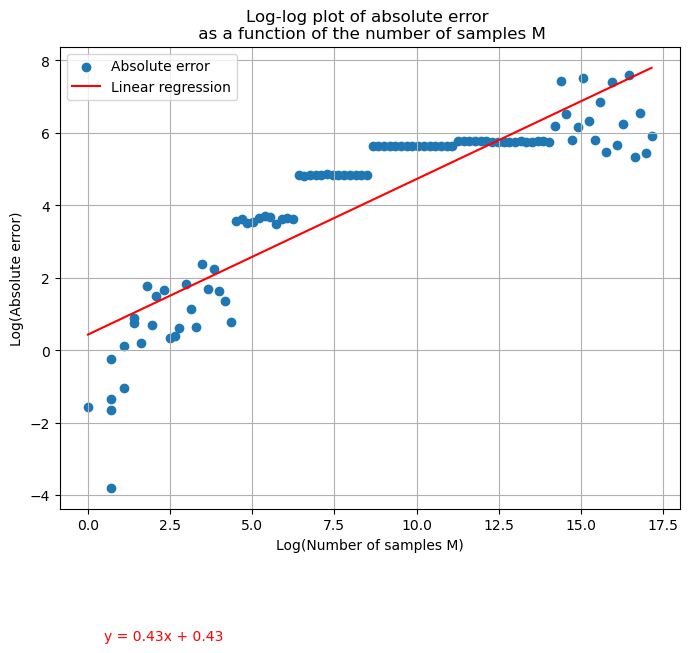

In [4]:
# plot log-log graph to see order of the error
loglog_graph(nb_samples, MCLS_estims, ref_value)

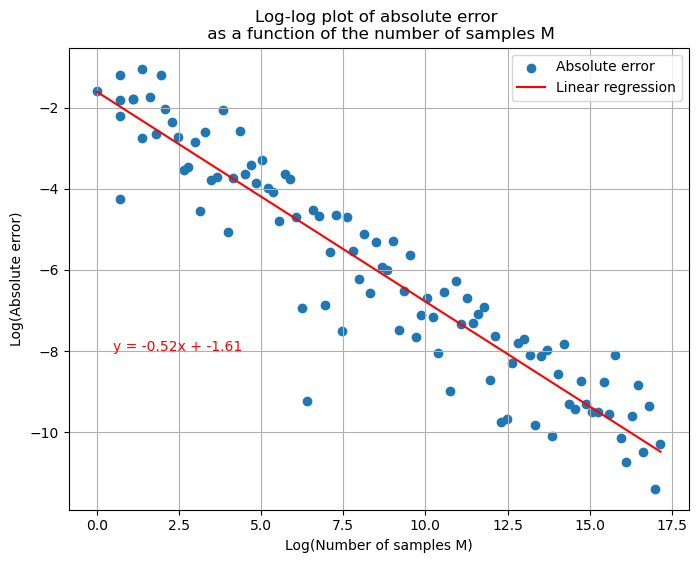

In [5]:
# plot log-log graph to see order of the error
loglog_graph(nb_samples, MCLS_prime_estims, ref_value)